In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip3 install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [2]:
data = pd.read_csv('Data/dataset_mood_smartphone.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [3]:
# add phaseOfDay as features
# Morning (5 AM to 12 PM)
# Afternoon (12 PM to 5 PM)
# Evening (5 PM to 10 PM)
# Night (10 PM to 5 AM)

# morning,afternoon,evening,night = 0,1,2,3

phaseOfDay = data.copy()
phaseOfDay['variable'] = 'phaseOfDay'
phases = []
for index,row in phaseOfDay.iterrows():
    time = int(row.time.split(' ')[1].split(':')[0])
    if time >= 5 and time < 12:
        phases.append(1)
    elif time >= 12 and time < 17:
        phases.append(2)
    elif time >= 17 and time < 22:
        phases.append(3)
    else:
        phases.append(4)

phaseOfDay['value'] = phases
data = data.append(phaseOfDay, ignore_index=True)

In [4]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 20 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather' 'phaseOfDay']
The average num of timesteps per user is 27919.4


Average mood is 6.993 with std of 1.033


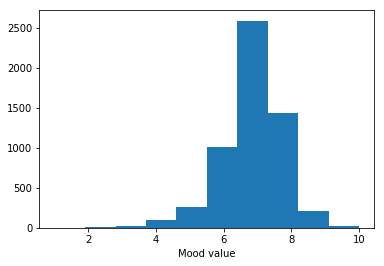

In [5]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


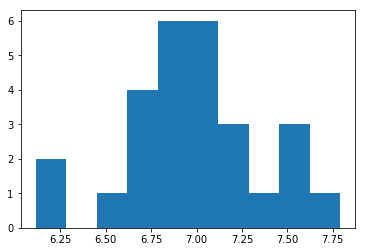

In [6]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()



In [7]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))






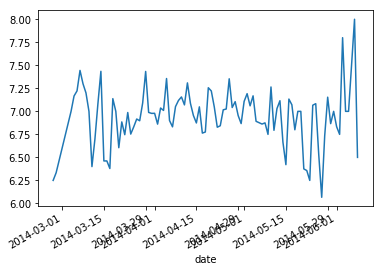

In [8]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [34]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence','activity','phaseOfDay']

#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()

# add dayofweek variable
date_data['dayofweek'] = date_data.index.get_level_values('date').dayofweek

# add leisure variable
date_data['leisure'] = (date_data['appCat.entertainment']+date_data['appCat.game'])

#target at day is the same as mood at day
date_data['target'] = date_data['mood']

#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)

#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
values0['leisure'] = 0
values0['social_anxiety'] = 0

date_data.fillna(value=values0, inplace=True)
#to do : think about values he didn't fill yet. although we have xgboost, so shouldn't be a problem

In [35]:
# get information about new features
date_data.corr(method='pearson')

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,...,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,phaseOfDay,dayofweek,leisure,target
mood,1.000000,0.152993,0.685359,0.167145,0.044152,0.027348,-0.042577,0.014362,0.052368,0.088933,...,0.083610,-0.050132,0.024135,0.030133,0.041556,0.018167,-0.029575,0.096071,0.120290,1.000000
circumplex.arousal,0.152993,1.000000,0.168875,-0.003677,-0.176939,0.030489,0.021351,0.035824,-0.168200,-0.084114,...,-0.088865,-0.096178,-0.012976,-0.033529,-0.005672,0.029122,-0.068226,-0.027663,-0.096147,0.152993
circumplex.valence,0.685359,0.168875,1.000000,0.166394,0.012797,-0.071553,-0.069134,-0.026888,0.058721,0.060914,...,0.104948,-0.071851,0.020100,0.069078,0.053298,-0.056605,-0.006118,0.089805,0.097707,0.685359
activity,0.167145,-0.003677,0.166394,1.000000,0.238639,0.142452,0.062664,0.067318,0.263075,0.053474,...,0.047147,-0.040604,0.125052,0.084462,-0.030539,-0.050464,0.069775,0.072627,0.151878,0.167145
screen,0.044152,-0.176939,0.012797,0.238639,1.000000,-0.072388,-0.047434,0.213792,0.777390,0.414522,...,0.296961,0.555446,0.143890,0.161062,0.253930,0.168130,0.015491,-0.031269,0.333314,0.044152
call,0.027348,0.030489,-0.071553,0.142452,-0.072388,1.000000,0.073229,0.004555,-0.086407,-0.071298,...,-0.071667,-0.083004,0.019751,-0.087921,-0.049058,-0.043161,0.003763,-0.034485,-0.085680,0.027348
sms,-0.042577,0.021351,-0.069134,0.062664,-0.047434,0.073229,1.000000,-0.019945,-0.045131,-0.051942,...,-0.049698,-0.029372,0.025262,-0.026361,-0.048393,-0.046846,-0.005896,-0.011444,-0.042240,-0.042577
appCat.builtin,0.014362,0.035824,-0.026888,0.067318,0.213792,0.004555,-0.019945,1.000000,0.085364,0.078891,...,0.017509,0.146724,0.041562,0.018901,0.064374,0.093890,0.016297,0.033000,0.069993,0.014362
appCat.communication,0.052368,-0.168200,0.058721,0.263075,0.777390,-0.086407,-0.045131,0.085364,1.000000,0.293118,...,0.293792,0.268651,0.080539,0.142862,0.155006,0.088101,0.009346,-0.058599,0.212416,0.052368
appCat.entertainment,0.088933,-0.084114,0.060914,0.053474,0.414522,-0.071298,-0.051942,0.078891,0.293118,1.000000,...,0.188938,0.122960,0.072340,0.107314,0.058280,0.052817,0.030567,0.015578,0.289383,0.088933


In [36]:
#rolling mean
lag = 10
rolling_variables  = date_data.columns
#for lag in range(1,max_lag):
for variable in rolling_variables:
    date_data["{}_lagged_by_{}".format(variable, lag)]=date_data[variable].rolling(window = lag).mean()

In [37]:
date_data.corr(method='pearson')['target_lagged_by_10']

mood                                 0.574183
circumplex.arousal                   0.069916
circumplex.valence                   0.249204
activity                             0.131942
screen                               0.132676
call                                 0.014495
sms                                 -0.057539
appCat.builtin                       0.057032
appCat.communication                 0.106036
appCat.entertainment                 0.134622
appCat.finance                       0.079218
appCat.game                          0.081794
appCat.office                        0.094340
appCat.other                         0.092477
appCat.social                       -0.007029
appCat.travel                        0.017231
appCat.unknown                       0.017914
appCat.utilities                     0.026096
appCat.weather                       0.063885
phaseOfDay                          -0.060373
dayofweek                            0.006403
leisure                           

In [38]:
#creating variables to drop
#BUG SLIDE TO T-1
list_var = list(rolling_variables)
list_var.remove('target')
#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets

date_data.dropna(axis = 0,subset = ["target"], inplace=True)


feature_data = np.array(date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =feature_data[:-1,1:], feature_data[1:,0]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [39]:
y_pred = model.predict(X_test)

#print(y_test, predictions)
accuracy = mean_squared_error(y_test, y_pred)
print("MSE: {:.4}" .format(accuracy))
print(X_test.shape)

MSE: 0.3524
(418, 23)


In [15]:
#baseline  MSE: 0.5868
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y[1:], x)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.5824


In [16]:
week_day_data = date_data.reset_index(level="date")

In [17]:
week_day_data['date']= pd.Timestamp.weekday()

TypeError: descriptor 'weekday' of 'datetime.date' object needs an argument

In [ ]:
date_data